# Credit Scoring Model

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import pickle
import json

import mlflow

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from xgboost import XGBClassifier
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn import pipeline as imblearn_pipeline

import shap

# Set random seed for reproducibility
RANDOM_STATE = 42

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MLflow Configuration

In [2]:
mlflow.set_experiment("OCP7_Optimized")
mlflow.set_tracking_uri("file:./mlruns")

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


## Memory Optimization Utilities

In [3]:
def reduce_memory_usage(df, verbose=True):
    """
    Reduce memory usage of a DataFrame by downcasting numeric types.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame
    verbose : bool
        Whether to print memory reduction info
        
    Returns
    -------
    pd.DataFrame
        DataFrame with optimized dtypes
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                # Use float32 instead of float64 for significant memory savings
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    
    if verbose:
        print(f'Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB '
              f'({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    
    return df


def clean_memory():
    """Force garbage collection to free memory."""
    gc.collect()

## Data Loading with Memory Optimization

In [4]:
# Load training data with memory optimization
train = pd.read_csv("train_8.csv", sep=",", low_memory=False)
print(f"Training data shape: {train.shape}")

# Optimize memory usage
train = reduce_memory_usage(train)

# Extract target and features
target = train['TARGET'].copy()
train.drop(columns=['TARGET', 'SK_ID_CURR'], inplace=True)
features_names = list(train.columns)

print(f"Number of features: {len(features_names)}")

Training data shape: (307511, 666)
Memory usage reduced from 1308.26 MB to 749.00 MB (42.7% reduction)
Number of features: 664


In [5]:
# Load test data (only if needed later)
# test = pd.read_csv("test_8.csv", sep=",", low_memory=False)
# test = reduce_memory_usage(test)
# print(f"Test data shape: {test.shape}")

In [6]:
# Convert to numpy arrays with float32 for memory efficiency
X = train.values.astype(np.float32)
y = target.values

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Free memory from original dataframe
del train, X
clean_memory()

Training set: (276759, 664)
Validation set: (30752, 664)


## Evaluation Metrics

For this project, we use several metrics to compare our models:

- **Accuracy**: Simple to interpret, doesn't capture all problem complexity but allows for simple comparisons.
- **ROC AUC**: Very useful metric for binary classification problems.
- **Business Cost Metric**: A custom metric requested by the project. A false positive (loan granted to a bad client) costs 10 times more than a false negative (loan denied to a good client). We consider a false negative as 1 and a false positive as 10, and aim to minimize this score.

In [7]:
def business_cost(y_true, y_pred):
    """
    Calculate business cost metric that penalizes false positives 10x more than false negatives.
    
    OPTIMIZED: Uses vectorized NumPy operations instead of Python loops.
    
    Parameters
    ----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted values
        
    Returns
    -------
    float
        Normalized cost score (lower is better)
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    
    # False Positives: predicted 0 (loan granted) but actual 1 (bad client) - costs 10
    # This is the dangerous case: giving loan to someone who won't repay
    false_positives = np.sum((y_pred == 0) & (y_true == 1))
    
    # False Negatives: predicted 1 (loan denied) but actual 0 (good client) - costs 1
    # This is lost business opportunity
    false_negatives = np.sum((y_pred == 1) & (y_true == 0))
    
    # Total cost normalized by number of predictions
    cost = (10 * false_positives + false_negatives) / len(y_pred)
    
    return cost


# Create scorer for cross-validation (negative because sklearn maximizes)
cost_scorer = make_scorer(business_cost, greater_is_better=False)

In [8]:
def get_scores(model, X_test, y_test):
    """
    Calculate all evaluation metrics for a model.
    
    Parameters
    ----------
    model : estimator
        Trained model with predict method
    X_test : array-like
        Test features
    y_test : array-like
        True labels
        
    Returns
    -------
    dict
        Dictionary with all scores
    """
    y_pred = model.predict(X_test)
    
    scores = {
        'Business Cost': business_cost(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred)
    }
    
    # Log to MLflow
    mlflow.log_metric("business_cost", scores['Business Cost'])
    mlflow.log_metric("accuracy", scores['Accuracy'])
    mlflow.log_metric("roc_auc", scores['ROC AUC'])
    
    return scores


# Initialize results DataFrame
results_df = pd.DataFrame(columns=["Business Cost", "Accuracy", "ROC AUC"])

## Baseline Model: Dummy Classifier

First, we build a naive model as a baseline. Since our classes are imbalanced, we'll get good accuracy by predicting 0 (good client) for everyone.

In [9]:
with mlflow.start_run(run_name="Baseline_Dummy"):
    dummy = DummyClassifier(strategy='constant', constant=0)
    dummy.fit(X_train, y_train)
    
    mlflow.log_param("strategy", 'constant')
    mlflow.log_param("constant", 0)
    
    results_df.loc["Dummy"] = get_scores(dummy, X_val, y_val)

print("Baseline Results:")
results_df

Baseline Results:


/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


,Business Cost,Accuracy,ROC AUC
Dummy,0.807427,0.919257,0.5


## Initial Tests: Without Class Imbalance Handling

First, we'll try simple models that don't account for class imbalance.

### Logistic Regression

This model doesn't handle missing values, so we need to impute.

In [10]:
# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Fit and transform training data
X_train_scaled = preprocessor.fit_transform(X_train).astype(np.float32)
X_val_scaled = preprocessor.transform(X_val).astype(np.float32)

print(f"Scaled training data shape: {X_train_scaled.shape}")

Scaled training data shape: (276759, 664)


In [11]:
# Logistic Regression with grid search
params_lr = {
    'penalty': ['l2'],
    'C': [10]
}

lr = LogisticRegression(max_iter=2000, n_jobs=-1)
grid_lr = GridSearchCV(lr, params_lr, scoring=cost_scorer, cv=3)
grid_lr.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_lr.best_params_}")

Best parameters: {'C': 10, 'penalty': 'l2'}


In [12]:
with mlflow.start_run(run_name="Logistic_Regression"):
    best_C = grid_lr.best_params_["C"]
    
    lr_model = LogisticRegression(penalty='l2', C=best_C, max_iter=10000, n_jobs=-1)
    lr_model.fit(X_train_scaled, y_train)
    
    mlflow.log_param('penalty', 'l2')
    mlflow.log_param('C', best_C)
    mlflow.log_param('max_iter', 10000)
    
    results_df.loc["Logistic Regression"] = get_scores(lr_model, X_val_scaled, y_val)

print("\nPrediction distribution:")
print(pd.Series(lr_model.predict(X_val_scaled)).value_counts())
print("\nThis model is barely better than baseline and predicts almost only 0s.")
results_df


Prediction distribution:
0    30587
1      165
Name: count, dtype: int64

This model is barely better than baseline and predicts almost only 0s.


,Business Cost,Accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
Logistic Regression,0.780957,0.919680,0.516578


### Random Forest

Using the same preprocessed data.

In [13]:
params_rf = {
    'n_estimators': [50],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)
grid_rf = GridSearchCV(rf, params_rf, scoring=cost_scorer, cv=3)
grid_rf.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_rf.best_params_}")

Best parameters: {'class_weight': 'balanced', 'n_estimators': 50}


In [14]:
with mlflow.start_run(run_name="Random_Forest"):
    n_estimators = grid_rf.best_params_["n_estimators"]
    
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators, 
        class_weight='balanced', 
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    rf_model.fit(X_train_scaled, y_train)
    
    mlflow.log_param("n_estimators", n_estimators)
    
    results_df.loc["Random Forest"] = get_scores(rf_model, X_val_scaled, y_val)

print("\nPrediction distribution:")
print(pd.Series(rf_model.predict(X_val_scaled)).value_counts())
print("\nLike before, this model predicts almost only 0s.")
results_df


Prediction distribution:
0    30742
1       10
Name: count, dtype: int64

Like before, this model predicts almost only 0s.


,Business Cost,Accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
Logistic Regression,0.780957,0.919680,0.516578
Random Forest,0.807037,0.919062,0.500261


### XGBoost

Testing with and without imputation, as XGBoost can handle missing values.

In [15]:
params_xgb = {
    'n_estimators': [200],
    'max_depth': [7],
    'learning_rate': [0.1],
    'min_child_weight': [0.5],
    'subsample': [0.5]
}

xgb = XGBClassifier(n_jobs=-1, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
grid_xgb = GridSearchCV(xgb, params_xgb, scoring=cost_scorer, cv=3)
grid_xgb.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_xgb.best_params_}")

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:02] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:11] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:17] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWar

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 0.5, 'n_estimators': 200, 'subsample': 0.5}


In [16]:
with mlflow.start_run(run_name="XGBoost_Imputed"):
    learning_rate = grid_xgb.best_params_["learning_rate"]
    
    xgb_model = XGBClassifier(
        learning_rate=learning_rate, 
        n_jobs=-1, 
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train_scaled, y_train)
    
    mlflow.log_param("learning_rate", learning_rate)
    
    results_df.loc["XGBoost (imputed)"] = get_scores(xgb_model, X_val_scaled, y_val)

print("\nPrediction distribution:")
print(pd.Series(xgb_model.predict(X_val_scaled)).value_counts())
results_df

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:33] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Prediction distribution:
0    30609
1      143
Name: count, dtype: int64


,Business Cost,Accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
Logistic Regression,0.780957,0.919680,0.516578
Random Forest,0.807037,0.919062,0.500261
XGBoost (imputed),0.782746,0.919940,0.515433


In [17]:
# XGBoost without imputation (only scaling)
scaler_only = MinMaxScaler()
X_train_only_scaled = scaler_only.fit_transform(X_train).astype(np.float32)
X_val_only_scaled = scaler_only.transform(X_val).astype(np.float32)

with mlflow.start_run(run_name="XGBoost_No_Imputation"):
    xgb_model_no_imp = XGBClassifier(
        learning_rate=learning_rate, 
        n_jobs=-1, 
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model_no_imp.fit(X_train_only_scaled, y_train)
    
    mlflow.log_param("learning_rate", learning_rate)
    
    results_df.loc["XGBoost (no imputation)"] = get_scores(xgb_model_no_imp, X_val_only_scaled, y_val)

print("\nPrediction distribution:")
print(pd.Series(xgb_model_no_imp.predict(X_val_only_scaled)).value_counts())
print("\nIn both cases, we still predict almost only 0s. Class imbalance handling is necessary.")
results_df

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:42] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Prediction distribution:
0    30593
1      159
Name: count, dtype: int64

In both cases, we still predict almost only 0s. Class imbalance handling is necessary.


,Business Cost,Accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
Logistic Regression,0.780957,0.919680,0.516578
Random Forest,0.807037,0.919062,0.500261
XGBoost (imputed),0.782746,0.919940,0.515433
XGBoost (no imputation),0.778974,0.920200,0.517779


## Class Imbalance Handling

There are several ways to handle class imbalance. We'll skip oversampling to avoid making the dataset even larger. We'll test undersampling instead.

### Random Undersampling

In [18]:
# Apply random undersampling
undersampler = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy=1)
X_balanced, y_balanced = undersampler.fit_resample(X_train_only_scaled, y_train)

print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"Class distribution: {np.bincount(y_balanced)}")

Balanced dataset shape: (44684, 664)
Class distribution: [22342 22342]


In [19]:
params_xgb_balanced = {
    'n_estimators': [200],
    'max_depth': [3],
    'learning_rate': [0.1],
    'min_child_weight': [1]
}

xgb_balanced = XGBClassifier(n_jobs=-1, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
grid_xgb_balanced = GridSearchCV(xgb_balanced, params_xgb_balanced, scoring=cost_scorer, cv=3)
grid_xgb_balanced.fit(X_balanced, y_balanced)

print(f"Best parameters: {grid_xgb_balanced.best_params_}")

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:48] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:50] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:51] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWar

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}


In [20]:
with mlflow.start_run(run_name="XGBoost_Undersampled"):
    best_params = grid_xgb_balanced.best_params_
    
    xgb_balanced_model = XGBClassifier(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_child_weight=best_params['min_child_weight'],
        n_jobs=-1,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_balanced_model.fit(X_balanced, y_balanced)
    
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    results_df.loc["XGBoost (undersampled)"] = get_scores(xgb_balanced_model, X_val_only_scaled, y_val)

print("\nSignificant improvement in business cost and ROC AUC compared to previous models!")
results_df

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:54] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Significant improvement in business cost and ROC AUC compared to previous models!


,Business Cost,Accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
Logistic Regression,0.780957,0.919680,0.516578
Random Forest,0.807037,0.919062,0.500261
XGBoost (imputed),0.782746,0.919940,0.515433
XGBoost (no imputation),0.778974,0.920200,0.517779
XGBoost (undersampled),0.505691,0.708539,0.707014


### SMOTE + Random Undersampling

Testing a combination of SMOTE (creating synthetic samples for minority class) and undersampling.

In [21]:
# SMOTE + Undersampling pipeline
smote_under_pipeline = imblearn_pipeline.Pipeline([
    ('smote', SMOTE(sampling_strategy=0.2, random_state=RANDOM_STATE)),
    ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE))
])

X_smoted, y_smoted = smote_under_pipeline.fit_resample(X_train_scaled, y_train)
print(f"SMOTE + Undersampled dataset shape: {X_smoted.shape}")

SMOTE + Undersampled dataset shape: (101766, 664)


In [22]:
params_xgb_smote = {
    'n_estimators': [200],
    'max_depth': [7],
    'learning_rate': [0.1],
    'min_child_weight': [1]
}

xgb_smote = XGBClassifier(n_jobs=-1, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
grid_xgb_smote = GridSearchCV(xgb_smote, params_xgb_smote, scoring=cost_scorer, cv=3)
grid_xgb_smote.fit(X_smoted, y_smoted)

print(f"Best parameters: {grid_xgb_smote.best_params_}")

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:58] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:56:04] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:56:10] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWar

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}


In [23]:
with mlflow.start_run(run_name="XGBoost_SMOTE_Undersampled"):
    best_params = grid_xgb_smote.best_params_
    
    xgb_smote_model = XGBClassifier(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_child_weight=best_params['min_child_weight'],
        n_jobs=-1,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_smote_model.fit(X_smoted, y_smoted)
    
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    results_df.loc["XGBoost (SMOTE + undersample)"] = get_scores(xgb_smote_model, X_val_only_scaled, y_val)

print("\nSMOTE + undersampling doesn't perform as well as undersampling alone.")
results_df

# Clean up SMOTE data to free memory
del X_smoted, y_smoted
clean_memory()

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:56:23] WARNING: /home/task_176476130134803/conda-bld/xgboost-split_1764761343514/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



SMOTE + undersampling doesn't perform as well as undersampling alone.


### LightGBM

Testing LightGBM with the balanced dataset (undersampling only) which gave the best results with XGBoost.

In [24]:
params_lgbm = {
    'n_estimators': [1000],
    'learning_rate': [0.05],
    'max_depth': [3],
    'reg_alpha': [0],
    'reg_lambda': [0]
}

lgbm = lgb.LGBMClassifier(
    objective='binary',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=-1
)

grid_lgbm = GridSearchCV(lgbm, params_lgbm, scoring=cost_scorer, cv=3)
grid_lgbm.fit(X_balanced, y_balanced)

print(f"Best parameters: {grid_lgbm.best_params_}")

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 0}


In [25]:
with mlflow.start_run(run_name="LightGBM_Balanced"):
    best_params = grid_lgbm.best_params_
    
    lgbm_model = lgb.LGBMClassifier(
        objective='binary',
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=-1
    )
    lgbm_model.fit(X_balanced, y_balanced)
    
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    results_df.loc["LightGBM (balanced)"] = get_scores(lgbm_model, X_val_only_scaled, y_val)
    
    # Log model
    mlflow.lightgbm.log_model(lgbm_model, "model")

print("\nLightGBM appears to be the best model. We'll continue with this one.")
results_df

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/12/06 15:56:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/06 15:56:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



LightGBM appears to be the best model. We'll continue with this one.


,Business Cost,Accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
Logistic Regression,0.780957,0.919680,0.516578
Random Forest,0.807037,0.919062,0.500261
XGBoost (imputed),0.782746,0.919940,0.515433
XGBoost (no imputation),0.778974,0.920200,0.517779
XGBoost (undersampled),0.505691,0.708539,0.707014
XGBoost (SMOTE + undersample),0.683500,0.557069,0.608096
LightGBM (balanced),0.495155,0.714978,0.713088


## Global Feature Importance

Now that we have a performant model, let's identify which features are most useful and which are least useful.

In [26]:
# Get feature importance from LightGBM
feature_importance = pd.DataFrame({
    'feature': features_names,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
feature_importance.head(10)

Top 10 most important features:


,feature,importance
27,EXT_SOURCE_3,206
660,CREDIT_TERM,196
25,EXT_SOURCE_1,196
26,EXT_SOURCE_2,159
9,DAYS_EMPLOYED,122
6,AMT_ANNUITY,111
8,DAYS_BIRTH,110
200,bureau_DAYS_CREDIT_ENDDATE_max,102
195,bureau_DAYS_CREDIT_max,98
339,previous_application_pos_cash_CNT_INSTALMENT_F...,96


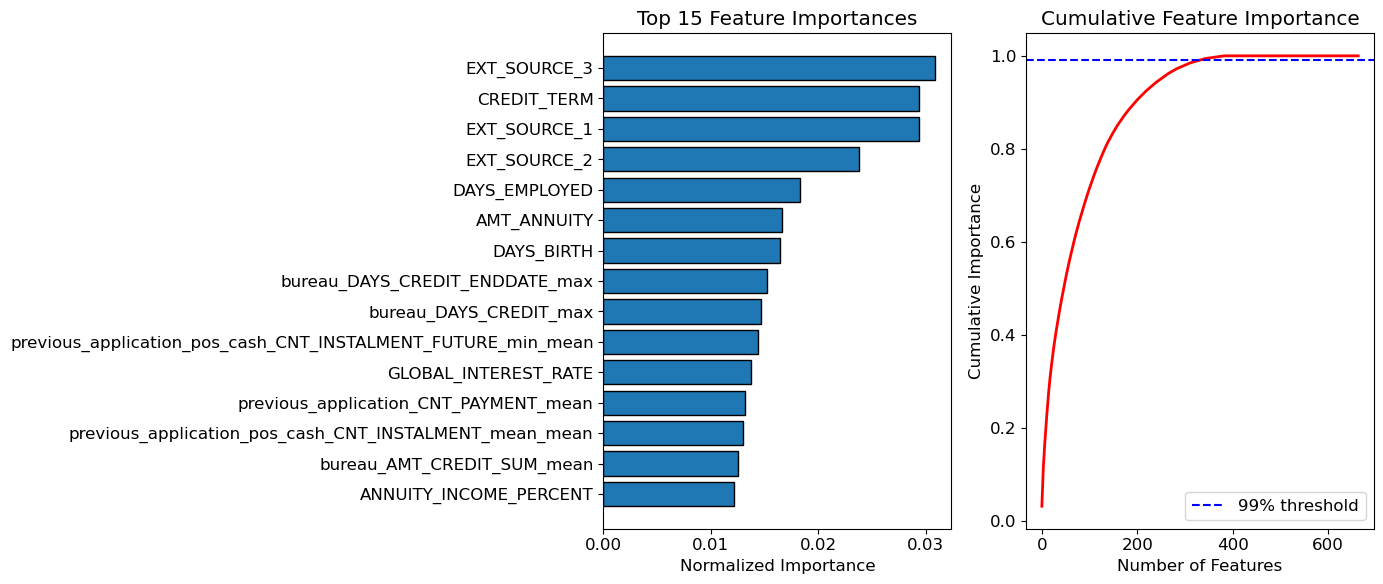

330 features required for 99% of cumulative importance


In [27]:
def plot_feature_importances(df, threshold=0.9):
    """
    Plot the top 15 most important features and cumulative importance curve.
    Shows the number of features needed to reach the specified threshold.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'feature' and 'importance' columns
    threshold : float
        Cumulative importance threshold (default 0.9)
        
    Returns
    -------
    pd.DataFrame
        DataFrame sorted by importance with normalized and cumulative columns
    """
    plt.rcParams['font.size'] = 12
    
    # Sort by importance
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)
    
    # Normalize and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    # Plot top 15 features
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar chart
    ax1 = axes[0]
    top_15 = df.head(15)
    ax1.barh(range(14, -1, -1), top_15['importance_normalized'], edgecolor='k')
    ax1.set_yticks(range(14, -1, -1))
    ax1.set_yticklabels(top_15['feature'])
    ax1.set_xlabel('Normalized Importance')
    ax1.set_title('Top 15 Feature Importances')
    
    # Cumulative importance
    ax2 = axes[1]
    ax2.plot(range(len(df)), df['cumulative_importance'], 'r-', linewidth=2)
    ax2.axhline(y=threshold, color='b', linestyle='--', label=f'{threshold:.0%} threshold')
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Cumulative Importance')
    ax2.set_title('Cumulative Feature Importance')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Find number of features for threshold
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print(f'{importance_index + 1} features required for {threshold:.0%} of cumulative importance')
    
    return df


feature_importance_df = plot_feature_importances(feature_importance, threshold=0.99)

In [28]:
# Identify features with zero importance
zero_importance_features = feature_importance_df[feature_importance_df['importance'] == 0]['feature'].tolist()
print(f'There are {len(zero_importance_features)} features with 0.0 importance')

if len(zero_importance_features) > 0:
    print("\nFeatures with zero importance (last 10):")
    print(feature_importance_df.tail(10))

There are 282 features with 0.0 importance

Features with zero importance (last 10):
                                               feature  importance  \
654   previous_application_credit_card_SK_DPD_min_mean           0   
655    previous_application_credit_card_SK_DPD_min_max           0   
656  previous_application_pos_cash_NAME_CONTRACT_ST...           0   
657  previous_application_credit_card_MONTHS_BALANC...           0   
658  previous_application_pos_cash_NAME_CONTRACT_ST...           0   
659  previous_application_pos_cash_NAME_CONTRACT_ST...           0   
660  previous_application_pos_cash_NAME_CONTRACT_ST...           0   
661  previous_application_pos_cash_NAME_CONTRACT_ST...           0   
662  previous_application_pos_cash_NAME_CONTRACT_ST...           0   
663  previous_application_pos_cash_NAME_CONTRACT_ST...           0   

     importance_normalized  cumulative_importance  
654                    0.0                    1.0  
655                    0.0              

## Decision Threshold Optimization

We have our best model. However, its decision threshold is 0.5, meaning it considers a client as defaulting when the probability exceeds 0.5. Let's optimize this threshold.

In [29]:
def find_optimal_threshold(model, X_val, y_val, n_thresholds=1000):
    """
    Find the optimal decision threshold by testing multiple values.
    
    OPTIMIZED: Uses vectorized operations instead of nested loops.
    
    Parameters
    ----------
    model : estimator
        Trained model with predict_proba method
    X_val : array-like
        Validation features
    y_val : array-like
        True labels
    n_thresholds : int
        Number of thresholds to test
        
    Returns
    -------
    pd.DataFrame
        DataFrame with threshold and corresponding cost, sorted by best cost
    """
    # Get probability predictions
    probas = model.predict_proba(X_val)[:, 1]
    y_true = np.asarray(y_val).ravel()
    
    # Generate thresholds
    thresholds = np.linspace(0, 1, n_thresholds + 1)[1:]  # Exclude 0
    
    # Vectorized cost calculation for all thresholds
    # Shape: (n_thresholds, n_samples)
    predictions = (probas[np.newaxis, :] > thresholds[:, np.newaxis]).astype(int)
    
    # Calculate costs vectorized
    # False positives: predicted 0 but actual 1 (costs 10)
    false_positives = np.sum((predictions == 0) & (y_true == 1), axis=1)
    # False negatives: predicted 1 but actual 0 (costs 1)
    false_negatives = np.sum((predictions == 1) & (y_true == 0), axis=1)
    
    costs = (10 * false_positives + false_negatives) / len(y_true)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Threshold': thresholds,
        'Cost': costs
    }).sort_values('Cost')
    
    return results


# Find optimal threshold
threshold_results = find_optimal_threshold(lgbm_model, X_val_only_scaled, y_val, n_thresholds=1000)

print("Top 10 thresholds by cost:")
threshold_results.head(10)

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Top 10 thresholds by cost:


,Threshold,Cost
501,0.502,0.492716
505,0.506,0.492911
503,0.504,0.492976
504,0.505,0.493074
502,0.503,0.493366
506,0.507,0.493529
500,0.501,0.493626
508,0.509,0.493854
543,0.544,0.493919
511,0.512,0.493952


In [30]:
optimal_threshold = threshold_results.iloc[0]['Threshold']
print(f"Optimal threshold: {optimal_threshold:.4f}")

# Save optimal threshold
with open("optimal_threshold.json", "w") as f:
    json.dump({"threshold": float(optimal_threshold)}, f)

Optimal threshold: 0.5020


## Local Feature Importance (SHAP)

Since the final goal is to interpret the model's response for each client, we need to study local feature importance. Let's look at a few examples.

In [31]:
# Create SHAP explainer
tree_explainer = shap.TreeExplainer(lgbm_model, X_balanced)

# Calculate SHAP values for first 3 validation samples
shap_values = tree_explainer(X_val_only_scaled[:3])
shap_values.feature_names = features_names

Example 1: This client is largely penalized by EXT_SOURCE_2.


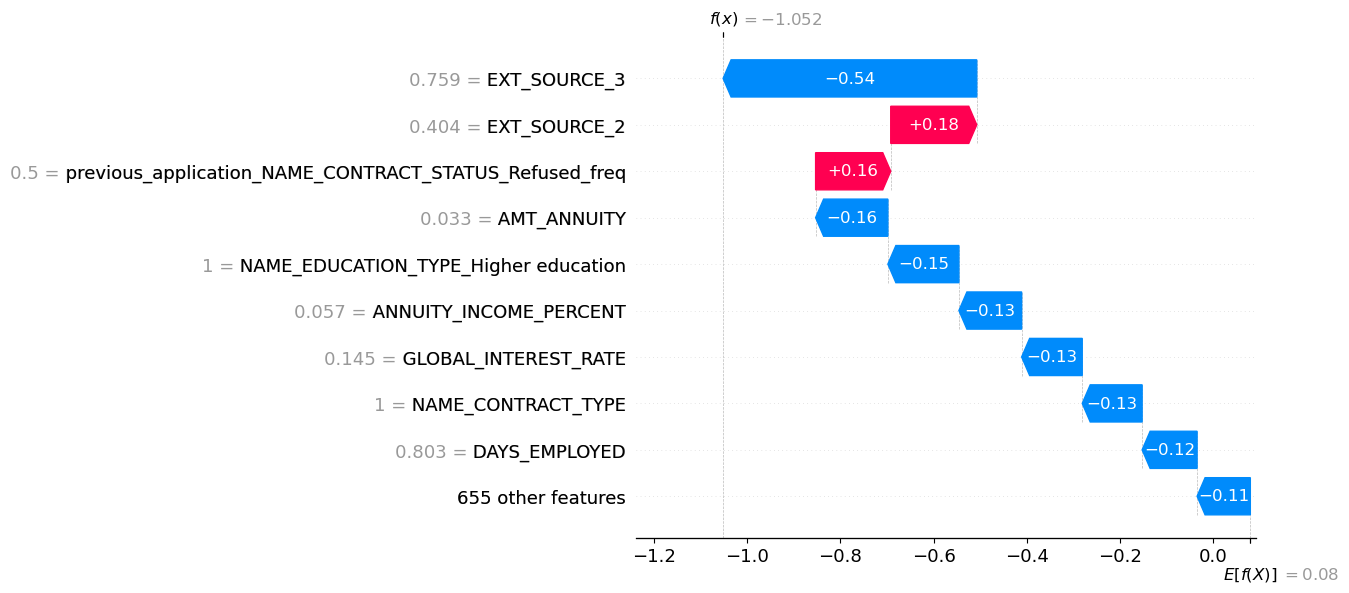

In [32]:
# Example 1
print("Example 1: This client is largely penalized by EXT_SOURCE_2.")
shap.waterfall_plot(shap_values[0])

Example 2: This client is favored by education level, interest rate, and age,
but penalized by ID document age.


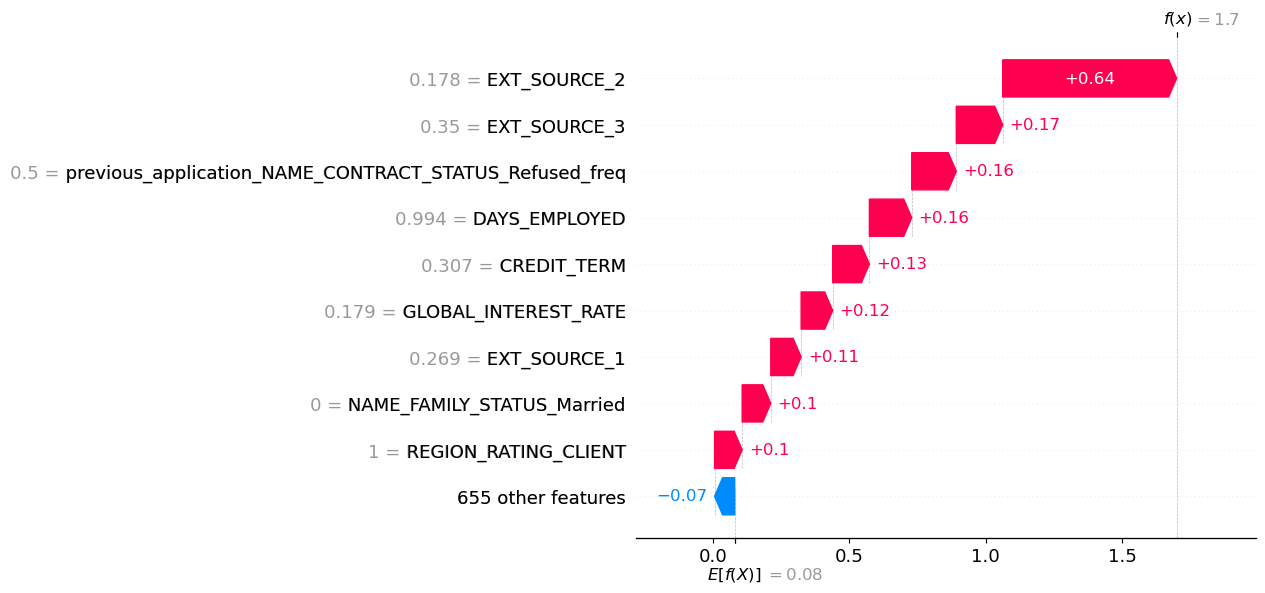

In [33]:
# Example 2
print("Example 2: This client is favored by education level, interest rate, and age,")
print("but penalized by ID document age.")
shap.waterfall_plot(shap_values[1])

Example 3: This client is greatly favored by EXT_SOURCE_2 and EXT_SOURCE_3.
Almost everything works in their favor.


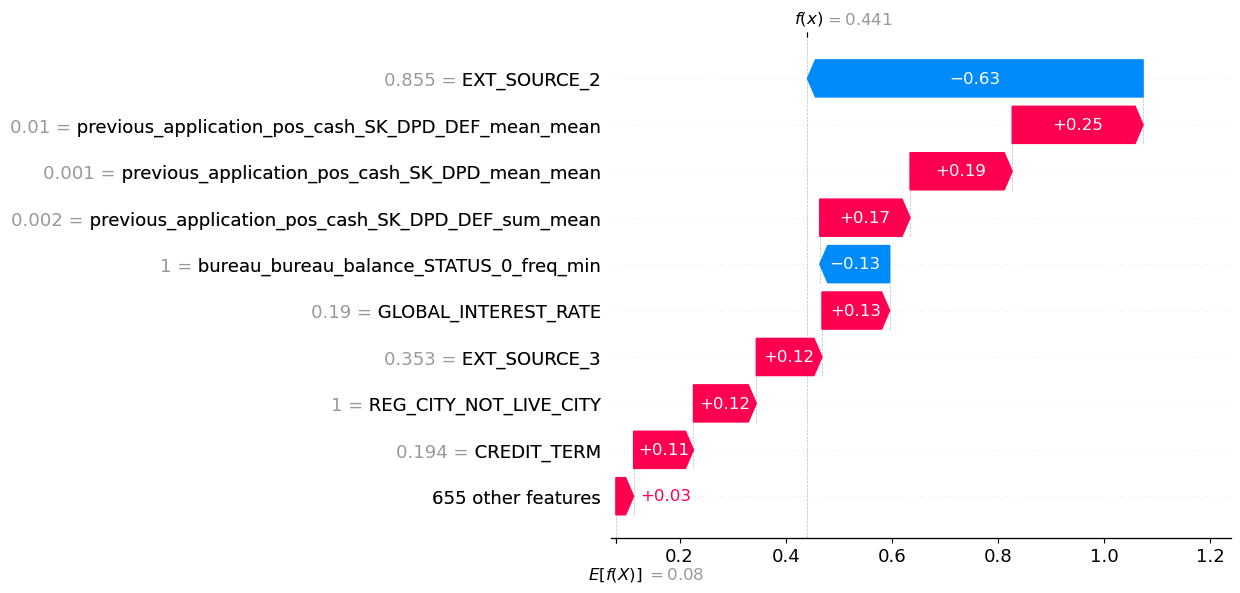

In [34]:
# Example 3
print("Example 3: This client is greatly favored by EXT_SOURCE_2 and EXT_SOURCE_3.")
print("Almost everything works in their favor.")
shap.waterfall_plot(shap_values[2])

## Final Model Export

Export the final model with all necessary components for deployment.

In [35]:
# Create final model pipeline
final_scaler = MinMaxScaler()
final_lgbm = lgb.LGBMClassifier(
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=3,
    reg_alpha=0,
    reg_lambda=0,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=-1
)

final_model = Pipeline([
    ('scaler', final_scaler),
    ('model', final_lgbm)
])

# Undersample training data
undersampler_final = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)
X_train_final, y_train_final = undersampler_final.fit_resample(X_train, y_train)

# Fit final model
final_model.fit(X_train_final, y_train_final)

print(f"Final model trained on {X_train_final.shape[0]} samples")

Final model trained on 44684 samples


In [36]:
with mlflow.start_run(run_name="Final_Model"):
    results_df.loc["Final Model"] = get_scores(final_model, X_val, y_val)

print("\nFinal Results:")
results_df


Final Results:


/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Business Cost,Accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
Logistic Regression,0.780957,0.919680,0.516578
Random Forest,0.807037,0.919062,0.500261
XGBoost (imputed),0.782746,0.919940,0.515433
XGBoost (no imputation),0.778974,0.920200,0.517779
XGBoost (undersampled),0.505691,0.708539,0.707014
XGBoost (SMOTE + undersample),0.683500,0.557069,0.608096
LightGBM (balanced),0.495155,0.714978,0.713088
Final Model,0.496716,0.713417,0.712239


In [37]:
# Find optimal threshold for final model
final_threshold_results = find_optimal_threshold(final_model, X_val, y_val, n_thresholds=1000)

print("Top 10 thresholds for final model:")
final_threshold_results.head(10)

/home/leo/anaconda3/envs/OCP7/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Top 10 thresholds for final model:


,Threshold,Cost
534,0.535,0.490862
533,0.534,0.491090
532,0.533,0.491220
528,0.529,0.491545
530,0.531,0.491545
531,0.532,0.491675
542,0.543,0.491675
544,0.545,0.491935
529,0.530,0.492033
526,0.527,0.492196


In [38]:
# Save threshold and model parameters
final_optimal_threshold = final_threshold_results.iloc[0]['Threshold']

params_to_save = pd.DataFrame({
    'Model threshold': [final_optimal_threshold * 100]
})
params_to_save.to_csv("useful_saved_parameters.csv", index=False)

print(f"Final optimal threshold: {final_optimal_threshold:.4f}")

Final optimal threshold: 0.5350


In [39]:
# Save the model
with open('selected_model.sav', 'wb') as f:
    pickle.dump(final_model, f)

print("Model saved to 'selected_model.sav'")

Model saved to 'selected_model.sav'


SHAP waterfall plot for first validation sample:


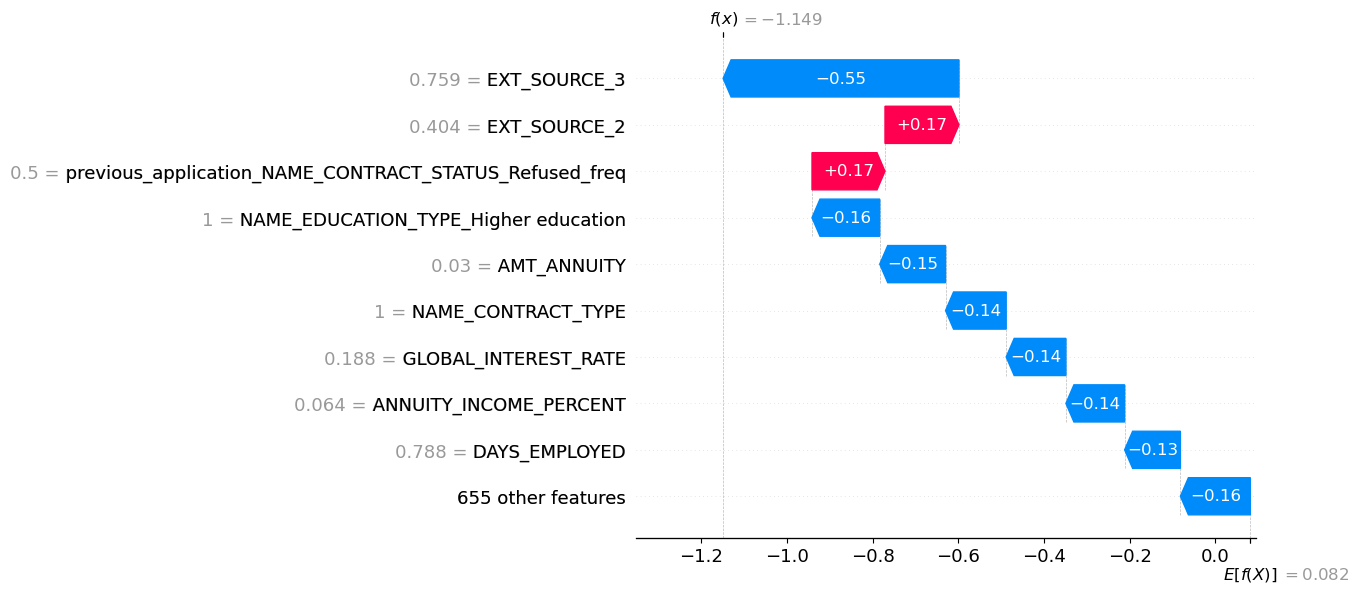

In [40]:
# Create and save SHAP explainer for the final model
X_train_scaled_final = final_model.named_steps['scaler'].transform(X_train_final)
final_explainer = shap.TreeExplainer(
    final_model.named_steps['model'], 
    X_train_scaled_final
)

# Test explainer
test_shap_values = final_explainer(final_model[:-1].transform(X_val[0].reshape(1, -1)))
test_shap_values.feature_names = features_names

print("SHAP waterfall plot for first validation sample:")
shap.waterfall_plot(test_shap_values[0])

In [41]:
# Save explainer
with open('explainer.sav', 'wb') as f:
    pickle.dump(final_explainer, f)

print("Explainer saved to 'explainer.sav'")

Explainer saved to 'explainer.sav'


In [42]:
# Save feature names for dashboard waterfall plot
with open('feature_names.sav', 'wb') as f:
    pickle.dump(features_names, f)

print("Feature names saved to 'feature_names.sav'")

Feature names saved to 'feature_names.sav'


In [43]:
# Final summary
print("="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nBest Model: LightGBM with Random Undersampling")
print(f"Optimal Threshold: {final_optimal_threshold:.4f}")
print(f"\nFinal Scores:")
print(results_df.loc["Final Model"])
print("\n" + "="*60)
print("Exported Files:")
print("  - selected_model.sav (trained model pipeline)")
print("  - explainer.sav (SHAP explainer)")
print("  - feature_names.sav (feature names list)")
print("  - useful_saved_parameters.csv (threshold)")
print("  - optimal_threshold.json (threshold in JSON format)")
print("="*60)

FINAL SUMMARY

Best Model: LightGBM with Random Undersampling
Optimal Threshold: 0.5350

Final Scores:
Business Cost    0.496716
Accuracy         0.713417
ROC AUC          0.712239
Name: Final Model, dtype: float64

Exported Files:
  - selected_model.sav (trained model pipeline)
  - explainer.sav (SHAP explainer)
  - feature_names.sav (feature names list)
  - useful_saved_parameters.csv (threshold)
  - optimal_threshold.json (threshold in JSON format)


In [44]:
# Clean up memory
clean_memory()
print("Memory cleaned.")

Memory cleaned.
